In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

%matplotlib inline

In [2]:
data = pd.read_csv("employee_retention_data.csv")
data.head()

,employee_id,company_id,dept,seniority,salary,join_date,quit_date
0,13021.0,7,customer_service,28,89000.0,2014-03-24,2015-10-30
1,825355.0,7,marketing,20,183000.0,2013-04-29,2014-04-04
2,927315.0,4,marketing,14,101000.0,2014-10-13,NaN
3,662910.0,7,customer_service,20,115000.0,2012-05-14,2013-06-07
4,256971.0,2,data_science,23,276000.0,2011-10-17,2014-08-22


# Data Preprocessing

In [3]:
data['is_quit'] = data.quit_date.notnull().astype('int')

data = data.fillna("2015-12-13")
data['quit_date'] = pd.to_datetime(data['quit_date'])
data['join_date'] = pd.to_datetime(data['join_date'])

data["stay_length"] = pd.to_numeric((data["quit_date"] - data["join_date"]).dt.days, downcast='integer')


In [4]:
data.head()

,employee_id,company_id,dept,seniority,salary,join_date,quit_date,is_quit,stay_length
0,13021.0,7,customer_service,28,89000.0,2014-03-24,2015-10-30,1,585
1,825355.0,7,marketing,20,183000.0,2013-04-29,2014-04-04,1,340
2,927315.0,4,marketing,14,101000.0,2014-10-13,2015-12-13,0,426
3,662910.0,7,customer_service,20,115000.0,2012-05-14,2013-06-07,1,389
4,256971.0,2,data_science,23,276000.0,2011-10-17,2014-08-22,1,1040


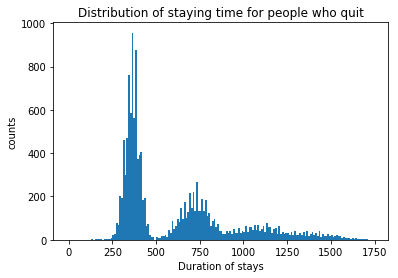

In [5]:
plt.clf()
plt.hist(data[data.is_quit == 1].stay_length, bins = np.arange(0,1750,10))
plt.title("Distribution of staying time for people who quit")
plt.xlabel("Duration of stays")
plt.ylabel("counts")
plt.show()

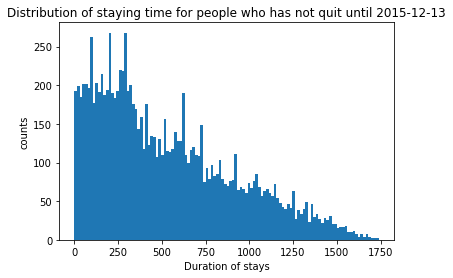

In [6]:
plt.clf()
plt.hist(data[data.is_quit == 0].stay_length, bins = np.arange(0,1750,15))
plt.title("Distribution of staying time for people who has not quit until 2015-12-13")
plt.xlabel("Duration of stays")
plt.ylabel("counts")
plt.show()

### Define our problem
From the distribution of the duration for people who quit, we can see there's a peak on around the first year, another center on the second year, and others more than 3 years. To simplify our problem, we first try to predict the early quit rate -- whether an employee will quit in the first year. 

We define a new variable __early_quit__:  
0 : people who quit < 500 days  
1 : people works > 500 days  

In [7]:
data_quit = data
data_quit['early_quit'] = -1
data_quit.loc[((data_quit['stay_length'] <= 500) & (data_quit['is_quit'] == 1)), 'early_quit'] = 1
data_quit.loc[(data_quit['stay_length'] > 500), 'early_quit'] = 0
data_quit = data_quit.loc[data_quit['early_quit'] != -1, :]

In [8]:
data_quit.early_quit.value_counts()

0    11202
1     7342
Name: early_quit, dtype: int64

We subset the original data, excluding those who work less than 500 days but haven't quit yet until 2015/12/13 - because we cannot know whether they will quit after 2015/12/13. Under the criteria, we get 18544 data points, with 11202 early quit and 7342 not early quit. 

Visualize the distribution fo two classes

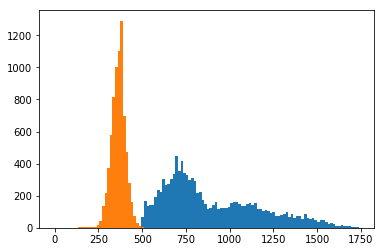

In [9]:
plt.clf()
plt.hist(data_quit[data_quit.early_quit == 0].stay_length, bins = np.arange(0,1750,15))
plt.hist(data_quit[data_quit.early_quit == 1].stay_length, bins = np.arange(0,1750,15))
plt.show()

# Exploratory Data Analysis

### Distribution of the Salary between two classes

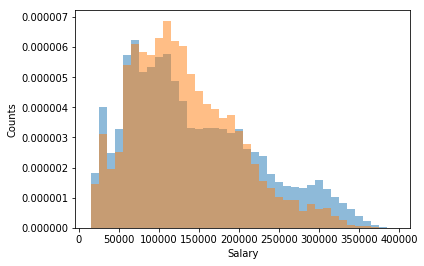

In [10]:
plt.clf()
plt.hist(data_quit[data_quit.early_quit == 0].salary, bins = np.arange(15000,400000, 10000), alpha = 0.5, density=True)
plt.hist(data_quit[data_quit.early_quit == 1].salary, bins = np.arange(15000,400000, 10000), alpha = 0.5, density=True)
plt.xlabel("Salary")
plt.ylabel("Counts")
plt.show()

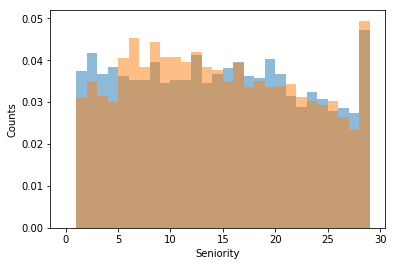

In [11]:
plt.clf()
plt.hist(data_quit[data_quit.early_quit == 0].seniority, bins = np.arange(0,30,1),alpha = 0.5, density=True)
plt.hist(data_quit[data_quit.early_quit == 1].seniority, bins = np.arange(0,30,1),alpha = 0.5, density=True)
plt.xlabel("Seniority")
plt.ylabel("Counts")
plt.show()

The distribution of salary and seniority do not look significantly different between two classes. We might need some feature engineer.

### Salary in different industry

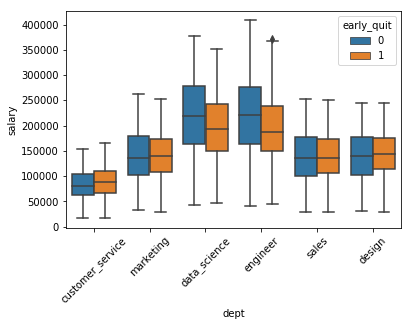

In [12]:
sns.boxplot(x="dept", y="salary", hue="early_quit", data=data_quit)
plt.xticks(rotation=45)
plt.show()

We can see the mean salary between different groups are quite different -- Data sciecne and engineer tends to earn more, while customer_service earn less. The salary should be compared with the same industry. Therefore we create a new adjusted salary - "sal_by_dept"

In [13]:
dept_avg_salary = data_quit.groupby('dept').salary.mean()
def get_dep_avg(data):
    avg_salary = dept_avg_salary[data['dept']]
    return data['salary']/avg_salary

data_quit['sal_by_dept'] = data_quit.apply(get_dep_avg, axis = 1)

/Users/sdcjimmy/anaconda2/envs/Insight/lib/python3.6/site-packages/ipykernel_launcher.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  


### Salary v.s seniority

<Figure size 432x288 with 0 Axes>

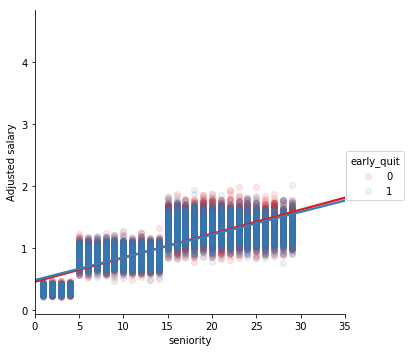

In [14]:
plt.clf()
sns.lmplot(x = 'seniority', y ='sal_by_dept', hue='early_quit', data = data_quit, palette="Set1", scatter_kws={'alpha':0.1})
#sns.regplot(data_quit['seniority'], data_quit['salary'])
plt.ylabel("Adjusted salary")
plt.xlim(0,35)
plt.show()

Usually the salary should go up with the seniority. The relationship between salary and seniority looks similar in the two groups. But we can see the slope of two groups are almost the same. Calculating salary/seniority probably would not help to predict the early quit probability a lot.

In [15]:
data_quit.head()

,employee_id,company_id,dept,seniority,salary,join_date,quit_date,is_quit,stay_length,early_quit,sal_by_dept
0,13021.0,7,customer_service,28,89000.0,2014-03-24,2015-10-30,1,585,0,1.078014
1,825355.0,7,marketing,20,183000.0,2013-04-29,2014-04-04,1,340,1,1.346746
3,662910.0,7,customer_service,20,115000.0,2012-05-14,2013-06-07,1,389,1,1.392940
4,256971.0,2,data_science,23,276000.0,2011-10-17,2014-08-22,1,1040,0,1.342904
5,509529.0,4,data_science,14,165000.0,2012-01-30,2013-08-30,1,578,0,0.802823


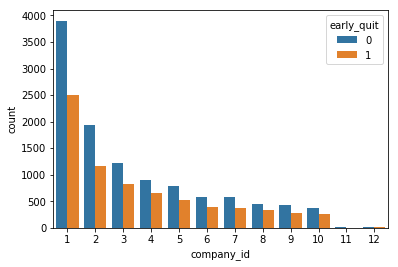

In [16]:
sns.countplot(hue = 'early_quit', x  = 'company_id', data = data_quit)

The ratio of early quit ratio are quite different in different companies

# Predicting the churn rate

In [17]:
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import OneHotEncoder, LabelBinarizer
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, classification_report, roc_curve, auc

In [18]:
data_quit.head()

,employee_id,company_id,dept,seniority,salary,join_date,quit_date,is_quit,stay_length,early_quit,sal_by_dept
0,13021.0,7,customer_service,28,89000.0,2014-03-24,2015-10-30,1,585,0,1.078014
1,825355.0,7,marketing,20,183000.0,2013-04-29,2014-04-04,1,340,1,1.346746
3,662910.0,7,customer_service,20,115000.0,2012-05-14,2013-06-07,1,389,1,1.392940
4,256971.0,2,data_science,23,276000.0,2011-10-17,2014-08-22,1,1040,0,1.342904
5,509529.0,4,data_science,14,165000.0,2012-01-30,2013-08-30,1,578,0,0.802823


Base on the EDA above, I choose the following features that should help to predict whether a employee will quit in one year:  
__dept__: the industry  
__salary__: the absolute value of the salary  
__sal_by_dept__: adjusted salary based on different field  
__seniority__: the year of work experience when hired  
__company_id__  

In [19]:
x = data_quit[["dept","sal_by_dept", "salary","seniority","company_id"]]
#x = data[["company_id","dept","seniority","salary","stay_length"]]
x = pd.get_dummies(x, columns=['dept',"company_id"])
y = data_quit['early_quit']

x_train, x_test, y_train, y_test = train_test_split(x,y, random_state= 999, test_size = 0.2)

In [20]:
y.value_counts()/sum(y.value_counts())

0    0.604077
1    0.395923
Name: early_quit, dtype: float64

## First Approach: Logistic Regression

In [21]:
lr = LogisticRegression(penalty='l1', class_weight={0:0.4,1:0.6})
lr.fit(x_train, y_train)
pred = lr.predict(x_test)
print(classification_report(y_test, pred))
print("Accuracy: %.3f" %(accuracy_score(y_test,pred)))

             precision    recall  f1-score   support

          0       0.62      0.48      0.54      2196
          1       0.43      0.57      0.49      1513

avg / total       0.54      0.52      0.52      3709

Accuracy: 0.519


Text(0.7,0.25,'ROC area: 0.547')

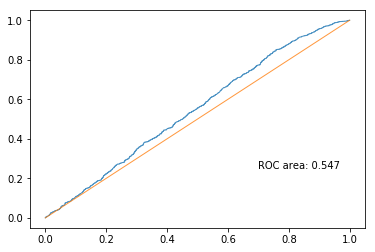

In [22]:
probas_ = lr.predict_proba(x_test)
# Compute ROC curve and area the curve
fpr, tpr, thresholds = roc_curve(y_test, probas_[:,1])
plt.plot(fpr, tpr, lw=1, alpha=0.8)
plt.plot([0, 1], [0, 1], lw=1, alpha=0.8)
plt.text(0.7, .25, "ROC area: %.3f" % auc(fpr, tpr))

### The correlation between features

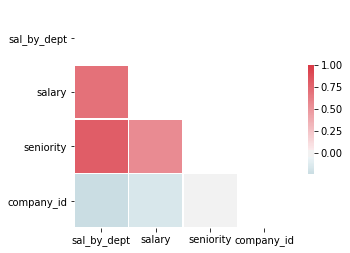

In [23]:
cor_data = data_quit[["dept","sal_by_dept", "salary","seniority","company_id"]]
corr = cor_data.corr()

mask = np.zeros_like(corr, dtype=np.bool)
mask[np.triu_indices_from(mask)] = True

# Generate a custom diverging colormap
cmap = sns.diverging_palette(220, 10, as_cmap=True)

# Draw the heatmap with the mask and correct aspect ratio
sns.heatmap(corr, mask=mask, cmap=cmap, center=0,
            square=True, linewidths=.5, cbar_kws={"shrink": .5})

## Second Approach: Random Forest

In [24]:
from sklearn.ensemble import RandomForestClassifier

In [25]:
rf = RandomForestClassifier(max_depth=8, random_state=0, n_estimators=100, class_weight={0:0.4,1:0.6})
rf.fit(x_train, y_train)
pred = rf.predict(x_test)
print(classification_report(y_test, pred)) 
print("Accuracy: %.3f" %(accuracy_score(y_test,pred)))

             precision    recall  f1-score   support

          0       0.65      0.46      0.54      2196
          1       0.45      0.63      0.52      1513

avg / total       0.56      0.53      0.53      3709

Accuracy: 0.531


Text(0.7,0.25,'ROC area: 0.547')

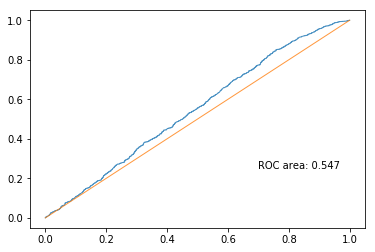

In [26]:
probas_ = lr.predict_proba(x_test)
# Compute ROC curve and area the curve
fpr, tpr, thresholds = roc_curve(y_test, probas_[:,1])
plt.plot(fpr, tpr, lw=1, alpha=0.8)
plt.plot([0, 1], [0, 1], lw=1, alpha=0.8)
plt.text(0.7, .25, "ROC area: %.3f" % auc(fpr, tpr))

### Interpret the feature importance on random forest

Feature ranking:
1. feature 1 sal_by_dept (0.376542)
2. feature 0 salary (0.254352)
3. feature 2 seniority (0.180465)
4. feature 6 dept_customer_service (0.030553)
5. feature 4 dept_data_science (0.014318)
6. feature 10 dept_design (0.013849)
7. feature 3 dept_engineer (0.013643)
8. feature 12 dept_marketing (0.011002)
9. feature 8 dept_sales (0.010564)
10. feature 13 company_id_1 (0.010474)
11. feature 14 company_id_2 (0.009967)
12. feature 16 company_id_3 (0.009833)
13. feature 17 company_id_4 (0.009581)
14. feature 5 company_id_5 (0.009383)
15. feature 9 company_id_6 (0.009354)
16. feature 7 company_id_7 (0.009204)
17. feature 11 company_id_8 (0.008031)
18. feature 18 company_id_9 (0.006832)
19. feature 15 company_id_10 (0.006464)
20. feature 20 company_id_11 (0.003034)
21. feature 19 company_id_12 (0.002554)


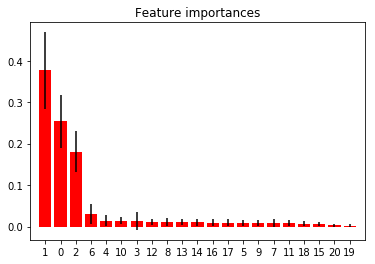

In [27]:
rf.feature_importances_

importances = rf.feature_importances_
std = np.std([tree.feature_importances_ for tree in rf.estimators_],axis=0)
indices = np.argsort(importances)[::-1]

# Print the feature ranking
print("Feature ranking:")

for f in range(x_test.shape[1]):
    print("%d. feature %d %s (%f)" % (f + 1, indices[f], x_test.columns[f], importances[indices[f]]))

# Plot the feature importances of the forest
plt.figure()
plt.title("Feature importances")
plt.bar(range(x_test.shape[1]), importances[indices],
       color="r", yerr=std[indices], align="center")
plt.xticks(range(x_test.shape[1]), indices)
plt.xlim([-1, x_test.shape[1]])
plt.show()

# Discussion

1. The results of both logistic regression and random forest are not pretty good. Given that we have around 60% of classes are 'early_quit", simply predict all the results to be 1 will give us around 60% of accuracy. However, both model gave around 0.51-0.53 of accuracy.  

2. Some features are highly correlated, therefore the interpretation of coefficient may be influence by the colinerity. Instead, we look at the feature importance in the random forest to determine the most important feature.
    - The result shows that the salary adjusted by the industry is the most important to see whether the employee will quit in a year -- if your salary is lower than the average in that industry, you have higher tendency to quit
    - The absolute value of salary and seniority comes next
    - The influence of industry and company itself do not matter that much
    
3. Potential methods to improve the model:
    - The labels are categorized into two classes based on the distribution of the work duration. However, there are actually three peaks in the histogram. It is reasonable to add more classes(quit in 1 year, 2 years, 3 years...) to capture the pattern more accurately. Nevertheless, adding classes would probably decrease the accuracy.
    - More feature engineer. The features we used seem not to explain the churn rate very well. There are other potential combination we can try to improve the results. Like use salary/seniority, square(seniority), log transform...
    - Different problem formulation: Instead of using the features to predict when will an employee quit, we can also use the features and the time of working to predict whether this employee will quit or not. Cause the longer you work, the higher chance you might quit.